RL Fall 99

Homework #4 - MDP

Ali Elahi SID: 810696336

MC - Off Policy

# Importing essential libraries

In [1]:
import random
import pprint
import io
import numpy as np
import sys
import numpy as np
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import bisect
from tqdm import tqdm

In [2]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.environment import EnvironmentBase
from amalearn.reward import GaussianReward
from amalearn.agent import RandomBanditAgent
from amalearn.agent import AgentBase

# Utils

In [4]:
def sliding_window(x):
    returns = []
    for i in range(len(x)-20):
        returns.append(np.array(x[i:i+20]).mean())
    return returns

# Class definitions

In [5]:
actions = {
    0: 'U',
    1: 'R',
    2: 'D',
    3: 'L'
}

In [6]:
%run Environment.ipynb

In [7]:
class MC_OffP_Agent(AgentBase):
    def __init__(self, id, environment, action_definition, gamma):
        super(MC_OffP_Agent, self).__init__(id, environment)
        
        self.Q = np.zeros((100, 4))
        self.C = np.zeros((100, 4))
        self.episode_num = 0
        self.behaviour = np.ones((100, 4)) / len(action_definition)
        self.policy = np.ones(100) * 3
        self.gamma = gamma
        self.epsilon = 1
    
    def show_policy(self):
        for i in range(10):
            for j in range(10):
                if (i, j) in [(1,3), (4, 1), (6,2)] :
                    print("•", end = " ")
                elif (i, j) in [(3,3), (3,4), (3,5), (4,3), (5,3), (5,4)] :
                    print("█", end = " ")
                else:
                    print(actions[self.policy[10 * i + j]], end = " ")
            print()
        
    def update_epsilon(self, x):
        x /= 40
        return 2 ** (1 - int(x)/40) / 2
    
    def get_action(self, state):
        return np.random.choice(4, 1, p = self.behaviour[state])[0]
    
    def create_behaviour(self):
        self.epsilon = self.update_epsilon(self.episode_num)
        for s in range(100):
            self.behaviour[s] = self.epsilon / 4
            self.behaviour[s][np.argmax(self.Q[s])] += (1 - self.epsilon)
    
    def update_ploicy(self, s, a):
        self.epsilon = self.update_epsilon(self.episode_num)
        self.policy[s] = self.epsilon / 4
        self.policy[s][a] += (1 - self.epsilon)
    
    def generate_episode(self, state = 45):
        self.environment.reset()
        terminate = False
        states_actions = []
        rewards = []
        while True:
            current = {}
            states_actions.append((state, self.get_action(state)))
            state, reward, done, info = self.environment.step(states_actions[-1][1])
            rewards.append(reward)
            if terminate:
                break
            if done:
                terminate = True
        return states_actions, rewards
    
    def take_action(self) -> (object, float, bool, object):
        self.episode_num += 1
        G = 0
        W = 1
        self.create_behaviour()
        states_actions, rewards = self.generate_episode()
        for i in range(len(states_actions) - 1, -1, -1):
            state, action = states_actions[i][0], states_actions[i][1]
            G = self.gamma * G + rewards[i]
            self.C[state][action] += W
            self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])
            if action != self.policy[state]:
                break
            W *= (1 / self.behaviour[state][action])
        for s in range(100):
            self.policy[s] = np.argmax(self.Q[s])
        return G

# Runing Algorithms

In [8]:
environment = GridworldEnv()
agent = MC_OffP_Agent('1', environment, actions, 1)

In [9]:
Gs = []
for i in tqdm(range(1200)):
    Gs.append(agent.take_action())

100%|██████████| 1200/1200 [00:25<00:00, 46.37it/s]


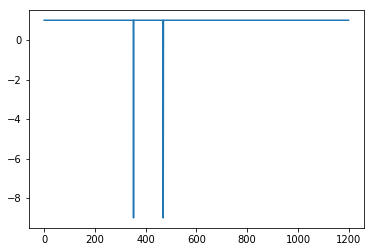

In [10]:
plt.plot(Gs)

In [11]:
agent.show_policy()

U U L L U U U U U U 
U U U • U U U U U U 
U D U U U U U U U U 
U U L █ █ █ U U U U 
U • U █ U U U U U U 
U U U █ █ U U U U U 
U U • U U U U U U U 
U U U U U U U U U U 
U U U U U U U U U U 
U U U U U U U U U U 
